In [295]:
import numpy as np
import matplotlib.pyplot as plt

# Задание 1
## Гаусс-Ньютон — реализация

In [296]:
class GaussNewton:
    def __init__(self, func, eps, max_iterations):
        self.func = func
        self.eps = eps
        self.max_iterations = max_iterations
        self.X = None
        self.Y = None
        self.B = None

    def fit(self, X, Y, B0):
        self.X = X
        self.Y = Y
        self.B = B0

        error_prev = np.inf
        final_iterations = 0
        for iteration in range(self.max_iterations):
            diff = self.calculateDiff(self.B)
            J = self.calculateJacobian(self.B)
            self.B -= self.pseudoInverse(J) @ diff
            error = np.sqrt(np.sum(diff**2))

            print(f"Iteration: {iteration}, error: {error}")

            error_diff = np.abs(error_prev - error)
            if error_diff < self.eps:
                return self.B

            error_prev = error
            final_iterations = iteration

        return self.B, final_iterations

    def calculateDiff(self, B):
        Y_pred = self.func(self.X, B)
        return Y_pred - self.Y

    def calculateJacobian(self, B0, step = 1e-6):
        Y0 = self.calculateDiff(B0)
        J = []
        for i, parameter in enumerate(B0):
            B = B0.copy()
            B[i] += step
            Y = self.calculateDiff(B)
            derivative = (Y - Y0) / step
            J.append(derivative)
        J = np.array(J).T

        return J

    def pseudoInverse(self, X):
        return np.linalg.inv(X.T @ X) @ X.T

    def fitFunction(self):
        return self.func(self.X, self.B)

In [297]:
def runGaussNewton(N = 10, eps = 1e-15, randCoeff = 0.2, max_iterations=1000):
    def func(X, B):
        return (B[0] + B[1] * X) / (X**2 + B[1]) + np.sin(X)

    def generateStartingValues():
        X = np.linspace(1, N, N)
        B = np.random.rand(2)
        Y = func(X, B) + randCoeff * np.random.rand(N)
        return X, B, Y

    X, B, Y = generateStartingValues()
    B0 = [0, 0]

    gauss_newton = GaussNewton(func, eps, max_iterations)
    Bf, iterations = gauss_newton.fit(X, Y, B0)
    fit = gauss_newton.fitFunction()
    print(X)
    print(fit)

    plt.figure(1, figsize=(6, 4), dpi=120)
    plt.scatter(X, Y, color='red')
    plt.plot(X, fit, color='blue', label='predicted')
    plt.plot(X, func(X, B0), color='yellow', label='starting')
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(f"iterations: {iterations}")
    plt.legend()
    plt.show()

## Гаусс-Ньютон — запуск

Iteration: 0, error: 1.609182110395516
Iteration: 1, error: 0.7775664157591446
Iteration: 2, error: 0.2155546734280625
Iteration: 3, error: 0.1821206038509614
Iteration: 4, error: 0.1820977849766237
Iteration: 5, error: 0.18209778209230218
Iteration: 6, error: 0.18209778209175953
Iteration: 7, error: 0.18209778209175942
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
[ 1.94913927  1.66725448  0.67231077 -0.357184   -0.64145934 -0.01716692
  0.87989757  1.18295262  0.58308038 -0.3910297 ]


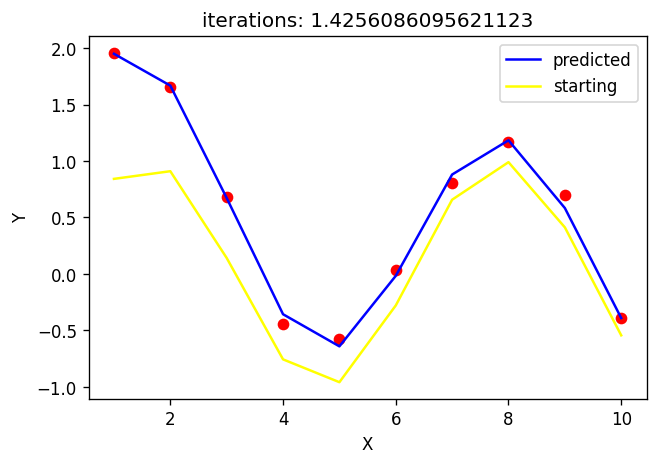

In [298]:
runGaussNewton()